# Note 3/2/2019

Accuracies based on various parameters

In this experiment, we are going to test the synthetic "MNIST" dataset, which is (very much) not linearly seperable. 

In [0]:
# !git clone https://github.com/wonjunee/mnist_gmu.git


  
# import os
# import shutil
# for i in (os.listdir('./mnist_gmu')):
#   shutil.move("./mnist_gmu/{}".format(i), ".")
  
# for i in (os.listdir('.')):
#   print(i)

In [2]:
from model_20190302 import *

import sys
import random

random.seed(702)

------ HELPER   FUNCTIONS IMPORTED ------
------ TRAINING FUNCTIONS IMPORTED ------
------ TEST     FUNCTIONS IMPORTED ------
Function is ready


In [0]:
# import tensorflow as tf

# with tf.device('/gpu:0'):
#     a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
#     b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
#     c = tf.matmul(a, b)

# with tf.Session() as sess:
#     print(sess.run(c))
    
# print("GPU is being used!")

# Bringing the Dataset

In [4]:
from helper.generate_data_mnist import *

SIZE = 100
reduced = True
padding = True
# Generate the data
X_train, X_test, y_train, y_test, y_train_one_hot, y_test_one_hot = mnist_generate_data(reduced=reduced, train_size = SIZE, padding=padding)


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.

Taking 100 per digit for train data
y train one hot encoding: (55000, 10)
y test one hot encoding: (10000, 10)

Training Set:   (55000, 32, 32, 1)
Test Set:       (10000, 32, 32, 1)
Done!


# Preprocessing

Shuffle the training data

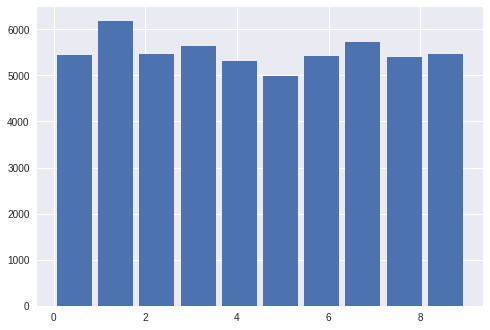

X_train: (55000, 32, 32, 1)
y_train: (55000, 1)


In [5]:
plt.hist(y_train, rwidth=0.85)
plt.show()

print("X_train:",X_train.shape)
print("y_train:",y_train.shape)

# Training

In [0]:
# learning rate
rate = 0.001

EPOCHS = 20
BATCH_SIZE = 128

# make sure to change this parameter!!!!!
filename_index = 0
date = 20190302

In [0]:
def evaluate(X_data, y_data):
    
    num_examples = len(X_data)
    sess = tf.get_default_session()
    
    accuracy = sess.run([accuracy_operation,correct_prediction,logits,fc4,fc6], feed_dict={x: X_data, y: y_data})
    
    return accuracy

In [0]:
# Matrix sizes for svm training
mat_type_list = ["2", "4", "6"]

tf_only  = []
tf_svm2  = []
tf_svm4  = []
tf_svm6  = []
    
# initialize x axis for plot
epochs_ranges = []

accuracy_tf  = []

accuracy_svc_linear = {}

for mat in mat_type_list:
    accuracy_svc_linear[mat] = []

x = tf.placeholder(tf.float32, (None, X_train.shape[1],X_train.shape[2],X_train.shape[3]), "x")
y = tf.placeholder(tf.int32, (None, 10), "y")

logits, fc4, fc6 = pipeline(x)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer(learning_rate = rate)

training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

accuracies = []

with tf.Session(config=tf.ConfigProto(log_device_placement=False)) as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)

    print("Training...")

    for i in range(EPOCHS):
        
        for offset in range(0, len(y_train), BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train_one_hot[offset:end]
            output_batch = sess.run([training_operation, logits, fc4, fc6], feed_dict={x: batch_x, y: batch_y})
            
            if offset == 0:
                Amat2,Amat4,Amat6 = output_batch[1:]
            else:
                Amat2 = np.append(Amat2, output_batch[1], axis=0)
                Amat4 = np.append(Amat4, output_batch[2], axis=0)
                Amat6 = np.append(Amat6, output_batch[3], axis=0)
                

#         if i % 200 == 0 and i > 5000:
        if True:
        
            print("\nEPOCHS:", i+1)
        
            print(Amat2.shape, Amat4.shape, Amat6.shape)

            epochs_ranges.append(i+1)

            print("\nTesting...")
            test_accuracy,prediction_tf,Amat2_test,Amat4_test,Amat6_test = evaluate(X_test, y_test_one_hot)

            print("\nTest Accuracy = {:.3f}".format(test_accuracy))
            
            tf_only.append(test_accuracy)

            accuracy_tf.append(test_accuracy)

            for train_mat_type in mat_type_list: # only 6 and 16

                if train_mat_type == "2":
                    train_matrix = Amat2.copy()
                    test_matrix  = Amat2_test.copy()
                elif train_mat_type == "4":
                    train_matrix = Amat4.copy()
                    test_matrix  = Amat4_test.copy()
                elif train_mat_type == "6":
                    train_matrix = Amat6.copy()
                    test_matrix  = Amat6_test.copy()                   

                # With linear kernel
                svc = SVC(kernel='linear')
                svc.fit(train_matrix, y_train)
                
                print("Y_train:",y_train.shape)
                print("Y_train:",y_test.shape)

                prediction = svc.predict(test_matrix)
                
                print("prediction:",prediction.shape)
                
                svc_linear_accuracy = np.sum(prediction==y_test.ravel())/len(prediction)

                print('\n train_mat_type: {}, Accuracy by SVC (linear): {}'.format(train_mat_type, svc_linear_accuracy))

                accuracy_svc_linear[train_mat_type].append(svc_linear_accuracy)

                # append accuracy to svm_only#
                if train_mat_type == "2":
                    tf_svm2.append(svc_linear_accuracy)
                elif train_mat_type == "4":
                    tf_svm4.append(svc_linear_accuracy)
                elif train_mat_type == "6":
                    tf_svm6.append(svc_linear_accuracy)

    for train_mat_type in mat_type_list:
        plt.figure(figsize=(10,5))
        plt.plot(epochs_ranges, accuracy_tf, 'o', label="TF")
        plt.plot(epochs_ranges, accuracy_svc_linear[train_mat_type], 'o',label="SVC (linear)")

        a = np.argmax(accuracy_tf)
        plt.annotate(accuracy_tf[a], (epochs_ranges[a], accuracy_tf[a]))

        a = np.argmax(accuracy_svc_linear[train_mat_type])
        plt.annotate(accuracy_svc_linear[train_mat_type][a], (epochs_ranges[a], accuracy_svc_linear[train_mat_type][a]))

        plt.legend()
        title  = "MNIST TF vs. SVC (linear) matrix size {}.png".format(train_mat_type)
        title1 = title
        

        plt.title(title1)
        plt.grid()
        plt.savefig(title)

        plt.show()
                
# np.savez("{}-multiple-runs-{}.npz".format(date,filename_index), \
#                         svm_only = svm_only, \
#                         tf_only  = tf_only, \
#                         tf_svm2  = tf_svm2, \
#                         tf_svm4  = tf_svm4, \
#                         tf_svm6  = tf_svm6)

import pickle
pickle.dump({"tf_only":tf_only, "tf_svm2":tf_svm2, "tf_svm4":tf_svm4, "tf_svm6":tf_svm6}, open("{}-{}.p"))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Training...

EPOCHS: 1
(55000, 10) (55000, 84) (55000, 1024)

Testing...

Test Accuracy = 0.959


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Y_train: (55000, 1)
Y_train: (10000, 1)
prediction: (10000,)

 train_mat_type: 2, Accuracy by SVC (linear): 0.9591


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Y_train: (55000, 1)
Y_train: (10000, 1)
prediction: (10000,)

 train_mat_type: 4, Accuracy by SVC (linear): 0.9581


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Y_train: (55000, 1)
Y_train: (10000, 1)
prediction: (10000,)

 train_mat_type: 6, Accuracy by SVC (linear): 0.97

EPOCHS: 2
(55000, 10) (55000, 84) (55000, 1024)

Testing...

Test Accuracy = 0.974


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Y_train: (55000, 1)
Y_train: (10000, 1)
prediction: (10000,)

 train_mat_type: 2, Accuracy by SVC (linear): 0.9743


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Y_train: (55000, 1)
Y_train: (10000, 1)
prediction: (10000,)

 train_mat_type: 4, Accuracy by SVC (linear): 0.9767


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Y_train: (55000, 1)
Y_train: (10000, 1)
prediction: (10000,)

 train_mat_type: 6, Accuracy by SVC (linear): 0.9823

EPOCHS: 3
(55000, 10) (55000, 84) (55000, 1024)

Testing...

Test Accuracy = 0.978


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Y_train: (55000, 1)
Y_train: (10000, 1)
prediction: (10000,)

 train_mat_type: 2, Accuracy by SVC (linear): 0.9788


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Y_train: (55000, 1)
Y_train: (10000, 1)
prediction: (10000,)

 train_mat_type: 4, Accuracy by SVC (linear): 0.9769


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Y_train: (55000, 1)
Y_train: (10000, 1)
prediction: (10000,)

 train_mat_type: 6, Accuracy by SVC (linear): 0.9832

EPOCHS: 4
(55000, 10) (55000, 84) (55000, 1024)

Testing...

Test Accuracy = 0.981


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Y_train: (55000, 1)
Y_train: (10000, 1)
prediction: (10000,)

 train_mat_type: 2, Accuracy by SVC (linear): 0.9814


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Y_train: (55000, 1)
Y_train: (10000, 1)
prediction: (10000,)

 train_mat_type: 4, Accuracy by SVC (linear): 0.9757


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Y_train: (55000, 1)
Y_train: (10000, 1)
prediction: (10000,)

 train_mat_type: 6, Accuracy by SVC (linear): 0.9838

EPOCHS: 5
(55000, 10) (55000, 84) (55000, 1024)

Testing...

Test Accuracy = 0.982


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Y_train: (55000, 1)
Y_train: (10000, 1)
prediction: (10000,)

 train_mat_type: 2, Accuracy by SVC (linear): 0.9829


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Y_train: (55000, 1)
Y_train: (10000, 1)
prediction: (10000,)

 train_mat_type: 4, Accuracy by SVC (linear): 0.9766


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Y_train: (55000, 1)
Y_train: (10000, 1)
prediction: (10000,)

 train_mat_type: 6, Accuracy by SVC (linear): 0.9845

EPOCHS: 6
(55000, 10) (55000, 84) (55000, 1024)

Testing...

Test Accuracy = 0.984


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Y_train: (55000, 1)
Y_train: (10000, 1)
prediction: (10000,)

 train_mat_type: 2, Accuracy by SVC (linear): 0.9839


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Y_train: (55000, 1)
Y_train: (10000, 1)
prediction: (10000,)

 train_mat_type: 4, Accuracy by SVC (linear): 0.9753


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Y_train: (55000, 1)
Y_train: (10000, 1)
prediction: (10000,)

 train_mat_type: 6, Accuracy by SVC (linear): 0.9844

EPOCHS: 7
(55000, 10) (55000, 84) (55000, 1024)

Testing...

Test Accuracy = 0.985


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Y_train: (55000, 1)
Y_train: (10000, 1)
prediction: (10000,)

 train_mat_type: 2, Accuracy by SVC (linear): 0.9845


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Y_train: (55000, 1)
Y_train: (10000, 1)
prediction: (10000,)

 train_mat_type: 4, Accuracy by SVC (linear): 0.9757


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Y_train: (55000, 1)
Y_train: (10000, 1)
prediction: (10000,)

 train_mat_type: 6, Accuracy by SVC (linear): 0.9852

EPOCHS: 8
(55000, 10) (55000, 84) (55000, 1024)

Testing...

Test Accuracy = 0.985


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Y_train: (55000, 1)
Y_train: (10000, 1)
prediction: (10000,)

 train_mat_type: 2, Accuracy by SVC (linear): 0.9853


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Y_train: (55000, 1)
Y_train: (10000, 1)
prediction: (10000,)

 train_mat_type: 4, Accuracy by SVC (linear): 0.9757


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Y_train: (55000, 1)
Y_train: (10000, 1)
prediction: (10000,)

 train_mat_type: 6, Accuracy by SVC (linear): 0.9849

EPOCHS: 9
(55000, 10) (55000, 84) (55000, 1024)

Testing...

Test Accuracy = 0.986


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Y_train: (55000, 1)
Y_train: (10000, 1)
prediction: (10000,)

 train_mat_type: 2, Accuracy by SVC (linear): 0.9855


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Y_train: (55000, 1)
Y_train: (10000, 1)
prediction: (10000,)

 train_mat_type: 4, Accuracy by SVC (linear): 0.9754


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Y_train: (55000, 1)
Y_train: (10000, 1)
prediction: (10000,)

 train_mat_type: 6, Accuracy by SVC (linear): 0.9856

EPOCHS: 10
(55000, 10) (55000, 84) (55000, 1024)

Testing...

Test Accuracy = 0.986


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Y_train: (55000, 1)
Y_train: (10000, 1)
prediction: (10000,)

 train_mat_type: 2, Accuracy by SVC (linear): 0.9861


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Y_train: (55000, 1)
Y_train: (10000, 1)
prediction: (10000,)

 train_mat_type: 4, Accuracy by SVC (linear): 0.9756


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Y_train: (55000, 1)
Y_train: (10000, 1)
prediction: (10000,)

 train_mat_type: 6, Accuracy by SVC (linear): 0.9854

EPOCHS: 11
(55000, 10) (55000, 84) (55000, 1024)

Testing...

Test Accuracy = 0.987


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Y_train: (55000, 1)
Y_train: (10000, 1)
prediction: (10000,)

 train_mat_type: 2, Accuracy by SVC (linear): 0.9866


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Y_train: (55000, 1)
Y_train: (10000, 1)
prediction: (10000,)

 train_mat_type: 4, Accuracy by SVC (linear): 0.9762


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Y_train: (55000, 1)
Y_train: (10000, 1)
prediction: (10000,)

 train_mat_type: 6, Accuracy by SVC (linear): 0.986

EPOCHS: 12
(55000, 10) (55000, 84) (55000, 1024)

Testing...

Test Accuracy = 0.986


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Y_train: (55000, 1)
Y_train: (10000, 1)
prediction: (10000,)

 train_mat_type: 2, Accuracy by SVC (linear): 0.9871


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Y_train: (55000, 1)
Y_train: (10000, 1)
prediction: (10000,)

 train_mat_type: 4, Accuracy by SVC (linear): 0.9757


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Y_train: (55000, 1)
Y_train: (10000, 1)
prediction: (10000,)

 train_mat_type: 6, Accuracy by SVC (linear): 0.9866

EPOCHS: 13
(55000, 10) (55000, 84) (55000, 1024)

Testing...

Test Accuracy = 0.987


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Y_train: (55000, 1)
Y_train: (10000, 1)
prediction: (10000,)

 train_mat_type: 2, Accuracy by SVC (linear): 0.9873


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Y_train: (55000, 1)
Y_train: (10000, 1)
prediction: (10000,)

 train_mat_type: 4, Accuracy by SVC (linear): 0.9762


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Y_train: (55000, 1)
Y_train: (10000, 1)
prediction: (10000,)

 train_mat_type: 6, Accuracy by SVC (linear): 0.9859

EPOCHS: 14
(55000, 10) (55000, 84) (55000, 1024)

Testing...

Test Accuracy = 0.987


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Y_train: (55000, 1)
Y_train: (10000, 1)
prediction: (10000,)

 train_mat_type: 2, Accuracy by SVC (linear): 0.9873


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Y_train: (55000, 1)
Y_train: (10000, 1)
prediction: (10000,)

 train_mat_type: 4, Accuracy by SVC (linear): 0.9759


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
npz_data = np.load("{}-multiple-runs-{}.npz".format(date,filename_index))

In [0]:
keys = npz_data.keys()

In [0]:
for i in keys:
    print(i)
    print(npz_data[i])
    print()